In [61]:
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd

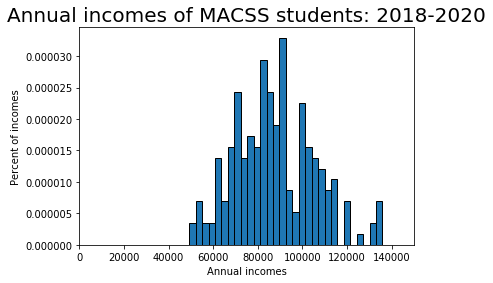

In [20]:
#1(a)
ics = np.loadtxt('incomes.txt')

num_bins = 30

plt.hist(ics, num_bins, normed=True, edgecolor='k')

plt.title('Annual incomes of MACSS students: 2018-2020', fontsize=20)
plt.xlabel(r'Annual incomes')
plt.ylabel(r'Percent of incomes')
plt.xlim([0, 150000])

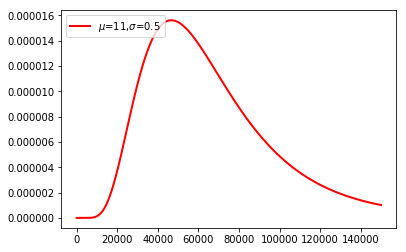

In [37]:
#1(b)
# Define function that generates values of a lognormal pdf (derived from Evans notes)
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, s=sigma, loc=mu, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, s=sigma, loc=mu, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, s=sigma, loc=mu, scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, s=sigma, loc=mu, scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

dist_pts = np.linspace(0.01, 150000, 5000)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1, sig_1, 0, 150000),
         linewidth=2, color='r', label='$\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

In [51]:
def log_lik_trunclognorm(xvals, mu, sigma, cut_lb, cut_ub):

    pdf_vals = trunc_lognorm_pdf(xvals, mu, abs(sigma), cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

log_lik_trunclognorm(ics, mu_1, sig_1, 0, 150000)

-2379.118351289667

In [42]:
#1(c)
def crit(params, *args):

    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_trunclognorm(xvals, mu, sigma, cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [53]:
mu_init = 11  # mu_2
sig_init = 0.5  # sig_2
params_init = np.array([mu_init, sig_init])
mle_args = (ics, 0, 150000)
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results_uncstr.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)
print("The value of log likelihood function is",-log_lik_trunclognorm(ics, mu_MLE, sig_MLE, 0, 150000))

mu_MLE= 11.361702970050843  sig_MLE= 0.21174671958723876
The value of log likelihood function is 2240.933432491611


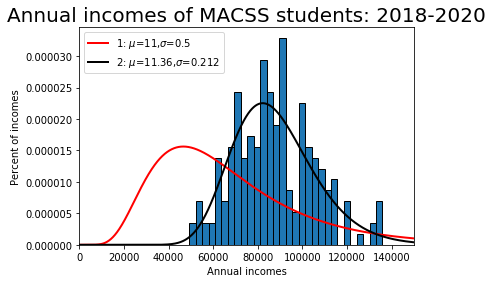

In [54]:
plt.hist(ics, num_bins, normed=True, edgecolor='k')

plt.title('Annual incomes of MACSS students: 2018-2020', fontsize=20)
plt.xlabel(r'Annual incomes')
plt.ylabel(r'Percent of incomes')
plt.xlim([0, 150000])

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1, sig_1, 0, 150000),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_MLE, sig_MLE, 0, 150000),
         linewidth=2, color='k', label='2: $\mu$=11.36,$\sigma$=0.212')
plt.legend(loc='upper left')

In [55]:
vcv_mle = results_uncstr.hess_inv

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[2.68284958e-04 4.20167719e-05]
 [4.20167719e-05 1.28722782e-04]]
Standard error for mu estimate =  0.01637940652333441
Standard error for sigma estimate =  0.011345606296013297


In [56]:
#1(d)
log_lik_h0 = log_lik_trunclognorm(ics, mu_1, sig_1, 0, 150000)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_trunclognorm(ics, mu_MLE, sig_MLE, 0, 150000)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

#We can reject the null hypothesis.

hypothesis value log likelihood -2379.118351289667
MLE log likelihood -2240.933432491611
likelihood ratio value 276.3698375961121
chi squared of H0 with 2 degrees of freedom p-value =  0.0


In [59]:
print('The probability that I will earn more than $100,000 is', 1-sts.lognorm.cdf(100000, sig_MLE, scale=np.exp(mu_MLE)))
print('The probability that I will earn less than $75,000 is', sts.lognorm.cdf(75000, sig_MLE, scale=np.exp(mu_MLE)))

The probability that I will earn more than $100,000 is 0.2375619958663785
The probability that I will earn less than $75,000 is 0.25964274747470995


In [66]:
#2(a)
data = pd.read_csv("sick.txt")
data.describe()

,sick,age,children,avgtemp_winter
count,200.000000,200.000000,200.000000,200.000000
mean,1.008600,40.683850,1.674950,44.041250
std,0.504222,11.268686,0.969761,11.101977
min,0.040000,12.810000,0.000000,16.500000
25%,0.650000,33.967500,0.970000,36.112500
50%,0.960000,41.015000,1.560000,43.300000
75%,1.322500,47.750000,2.322500,52.172500
max,2.800000,74.890000,4.960000,68.600000


In [87]:
def log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sigma):
    res = y - b0 - b1 * x1 - b2 * x2 - b3 * x3
    pdf_vals = sts.norm.pdf(res, loc=0, scale=abs(sigma))
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit_2(params,*args):
    
    b0, b1, b2, b3, sigma = params
    y, x1, x2, x3 = args
    log_lik_val = log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sigma)
    neg_log_lik_val = -log_lik_val 
    
    return neg_log_lik_val

In [98]:
b0_init, b1_init, b2_init, b3_init, sigma_init = (1, 0, 0, 0, 1)
params_init2 = np.array([b0_init, b1_init, b2_init, b3_init, sigma_init])
x1, x2, x3, y = data['age'], data['children'], data['avgtemp_winter'], data['sick']
mle_args2 = (y, x1, x2, x3)

results = opt.minimize(crit_2, params_init2, args=(mle_args2))
b0_MLE, b1_MLE, b2_MLE, b3_MLE, sigma_MLE = results.x
vcv_mle2 = results.hess_inv
log_like_mle2 = -results.fun


print('beta_0 =', b0_MLE)
print('beta_1 =', b1_MLE)
print('beta_2 =', b2_MLE)
print('beta_3 =', b3_MLE)
print('sigma =', sig_MLE)
print("The value of the log likelihood function is", log_like_mle2)
print('VCV(MLE) = ', vcv_mle2)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
D:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
D:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


beta_0 = 0.2516463912346375
beta_1 = 0.012933349828403056
beta_2 = 0.40050203066366546
beta_3 = -0.009991672274396013
sigma = 0.003018019036541892
The value of the log likelihood function is 876.8650464622724
VCV(MLE) =  [[ 8.22495697e-07  2.43442160e-09 -8.51686071e-08 -1.64385490e-08
  -1.04226306e-08]
 [ 2.43442160e-09  3.51359196e-09 -2.86001506e-08 -2.21091227e-09
  -8.70388912e-11]
 [-8.51686071e-08 -2.86001506e-08  2.59058021e-07  1.83503648e-08
   1.89210383e-09]
 [-1.64385490e-08 -2.21091227e-09  1.83503648e-08  1.71297164e-09
   2.21519232e-10]
 [-1.04226306e-08 -8.70388912e-11  1.89210383e-09  2.21519232e-10
   2.01528997e-08]]


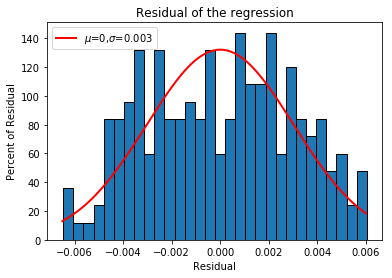

In [95]:
plt.hist(y - b0_MLE - b1_MLE * x1 - b2_MLE * x2 - b3_MLE * x3, num_bins, normed=True, edgecolor='k')

dist_pts=np.linspace(-0.0065,0.006,1000)
plt.plot(dist_pts, norm_pdf(dist_pts, sig_MLE),
         linewidth=2, color='r', label='$\mu$=0,$\sigma$=0.003')
plt.legend(loc='upper left', fontsize=10)

plt.title('Residual of the regression')
plt.xlabel('Residual')
plt.ylabel('Percent of Residual')
plt.show()

In [100]:
b0_2, sigma_2, b1_2, b2_2, b3_2 = 1, 0.1, 0, 0, 0
log_like_h02 = log_lik_norm(y, x1, x2, x3, b0_2, b1_2, b2_2, b3_2, sigma_2)

LR_val2 = 2 * (log_like_mle2 - log_like_h02)

pval_h02 = 1.0 - sts.chi2.cdf(LR_val2, 5)
print('The likelihood that these variables have no effect on being sick is', pval_h02)

The likelihood that these variables have no effect on being sick is 0.0
